# Notebook 3: Explainable AI (XAI) with SHAP

## Objective
This notebook focuses on:
1. Using SHAP (SHapley Additive exPlanations) to explain model predictions
2. Understanding which features contribute most to predictions
3. Creating visualizations for model interpretability
4. Generating explanations that can be used in the Streamlit app

## Why SHAP Matters
- Helps healthcare workers understand why a patient is at risk
- Builds trust in the AI system
- Provides actionable insights for treatment decisions
- Important for regulatory compliance in healthcare


## Step 1: Import Required Libraries


In [5]:
# Data manipulation
import pandas as pd
import numpy as np
import json
import joblib

# SHAP for explainability
import shap

# Visualization
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

# Initialize SHAP (suppresses warnings)
shap.initjs()

print("Libraries imported successfully!")
print("SHAP version:", shap.__version__)


Libraries imported successfully!
SHAP version: 0.50.0


## Step 2: Load Model and Data


In [ ]:
# Load the best model
model = joblib.load('../models/best_model_pipeline.pkl')

# Load model metadata
with open('../models/model_metadata.json', 'r') as f:
    model_metadata = json.load(f)

# Load data
df = pd.read_csv('../data/cleaned_diabetes_dataset.csv')

# Get selected features
selected_features = model_metadata['features']
X = df[selected_features]
y = df['Outcome']

print("=" * 60)
print("MODEL AND DATA LOADED")
print("=" * 60)
print(f"\nModel Type: {model_metadata['model_name']}")
print(f"Features: {selected_features}")
print(f"Data shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")


MODEL AND DATA LOADED

Model Type: LightGBM
Features: ['Age', 'BMI', 'BloodPressure', 'Glucose', 'DiabetesPedigreeFunction', 'Insulin', 'Pregnancies']
Data shape: (768, 7)
Target distribution: {0: 500, 1: 268}


## Step 3: Create SHAP Explainer

SHAP explainers work differently depending on the model type. We'll use the appropriate explainer.


In [7]:
# Select a sample of data for SHAP (using all data can be slow)
# Use a representative sample
sample_size = min(100, len(X))
X_sample = X.sample(n=sample_size, random_state=42)

print("=" * 60)
print("CREATING SHAP EXPLAINER")
print("=" * 60)
print(f"\nUsing {sample_size} samples for SHAP explanation")

# Determine the appropriate explainer based on model type
model_type = model_metadata['model_type']

if 'Tree' in model_type or 'Forest' in model_type or 'XGB' in model_type or 'LGBM' in model_type:
    # Tree-based models: Use TreeExplainer (fast and exact)
    print("\nUsing TreeExplainer (for tree-based models)...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # For binary classification, shap_values might be:
    # - A list of arrays (one per class)
    # - A 3D array (samples, features, classes)
    # - A 2D array (samples, features) if already extracted
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class (diabetes) values
    elif len(shap_values.shape) == 3:
        # 3D array: (samples, features, classes) - keep as is for now, will extract in Cell 8
        print(f"SHAP values are 3D: {shap_values.shape} - will extract positive class later")
else:
    # For other models (Logistic Regression, SVM), use KernelExplainer
    print("\nUsing KernelExplainer (for non-tree models)...")
    # Use a smaller background dataset
    background_size = min(50, len(X))
    X_background = X.sample(n=background_size, random_state=42)
    explainer = shap.KernelExplainer(model.predict_proba, X_background)
    shap_values = explainer.shap_values(X_sample)
    
    # For binary classification, use positive class
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    elif len(shap_values.shape) == 3:
        # 3D array - keep as is for now
        print(f"SHAP values are 3D: {shap_values.shape} - will extract positive class later")

print("✓ SHAP explainer created successfully!")
print(f"SHAP values shape: {shap_values.shape}")


CREATING SHAP EXPLAINER

Using 100 samples for SHAP explanation

Using TreeExplainer (for tree-based models)...
✓ SHAP explainer created successfully!
SHAP values shape: (100, 7)


c:\Users\deirw\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


## Step 4: Global Feature Importance

This shows which features are most important overall for the model's predictions.


GLOBAL FEATURE IMPORTANCE (SHAP)


C:\Users\deirw\AppData\Local\Temp\ipykernel_12808\1243930486.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, X_sample, show=False)


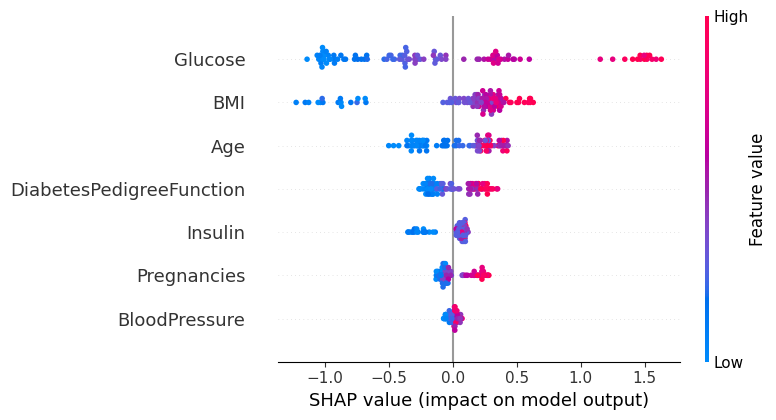

C:\Users\deirw\AppData\Local\Temp\ipykernel_12808\1243930486.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, X_sample, plot_type="bar", show=False)


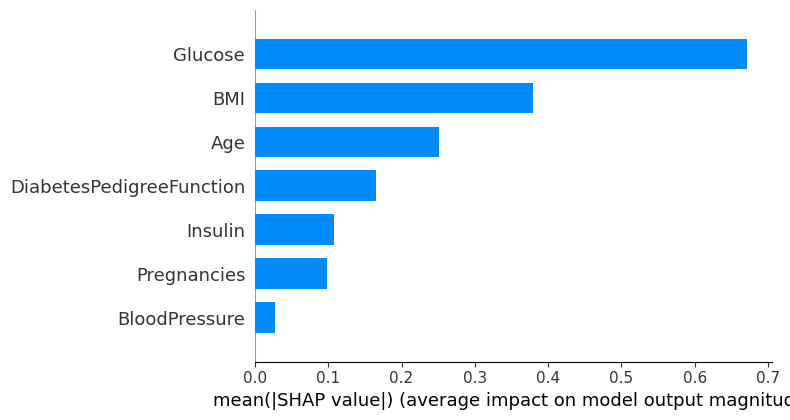


Mean Absolute SHAP Values (Feature Importance):
                 Feature  Mean |SHAP Value|
                 Glucose           0.671456
                     BMI           0.379690
                     Age           0.250960
DiabetesPedigreeFunction           0.164937
                 Insulin           0.108037
             Pregnancies           0.098816
           BloodPressure           0.027763


In [8]:
# Summary plot - shows feature importance
print("=" * 60)
print("GLOBAL FEATURE IMPORTANCE (SHAP)")
print("=" * 60)

# Handle SHAP values shape - for binary classification, shap_values might be 3D
# Shape could be (samples, features) or (samples, features, classes)
if len(shap_values.shape) == 3:
    # For binary classification, use positive class (diabetes) values
    shap_values_2d = shap_values[:, :, 1]  # Extract class 1 (diabetes) SHAP values
    print(f"SHAP values shape: {shap_values.shape} -> Using positive class values")
else:
    shap_values_2d = shap_values

# Create summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_2d, X_sample, show=False)
plt.tight_layout()
plt.show()

# Bar plot of mean absolute SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_2d, X_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# Calculate mean absolute SHAP values for each feature
# shap_values_2d should now be (samples, features), so mean(axis=0) gives (features,)
mean_abs_shap = np.abs(shap_values_2d).mean(axis=0)

# Ensure it's 1D
if len(mean_abs_shap.shape) > 1:
    mean_abs_shap = mean_abs_shap.flatten()

mean_shap = pd.DataFrame({
    'Feature': X_sample.columns,
    'Mean |SHAP Value|': mean_abs_shap
}).sort_values('Mean |SHAP Value|', ascending=False)

print("\nMean Absolute SHAP Values (Feature Importance):")
print(mean_shap.to_string(index=False))


## Step 5: Individual Prediction Explanations

Let's explain a few individual predictions to understand how the model makes decisions.


INDIVIDUAL PREDICTION EXPLANATIONS

Example 11:
  Actual Outcome: Diabetes
  Predicted Probability (Diabetes): 0.567
  Predicted Probability (No Diabetes): 0.433
  Predicted Class: Diabetes

  Feature Values:
    Age: 40.00
    BMI: 27.50
    BloodPressure: 70.00
    Glucose: 111.00
    DiabetesPedigreeFunction: 0.14
    Insulin: 125.00
    Pregnancies: 10.00

  SHAP Feature Contributions:


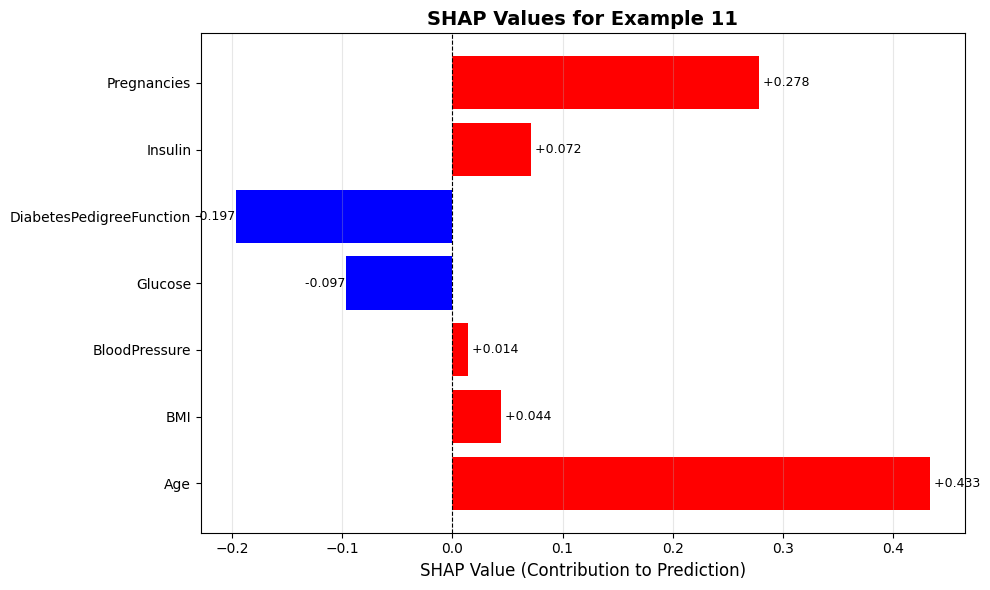


Example 1:
  Actual Outcome: No Diabetes
  Predicted Probability (Diabetes): 0.412
  Predicted Probability (No Diabetes): 0.588
  Predicted Class: No Diabetes

  Feature Values:
    Age: 43.00
    BMI: 34.00
    BloodPressure: 58.00
    Glucose: 98.00
    DiabetesPedigreeFunction: 0.43
    Insulin: 190.00
    Pregnancies: 6.00

  SHAP Feature Contributions:


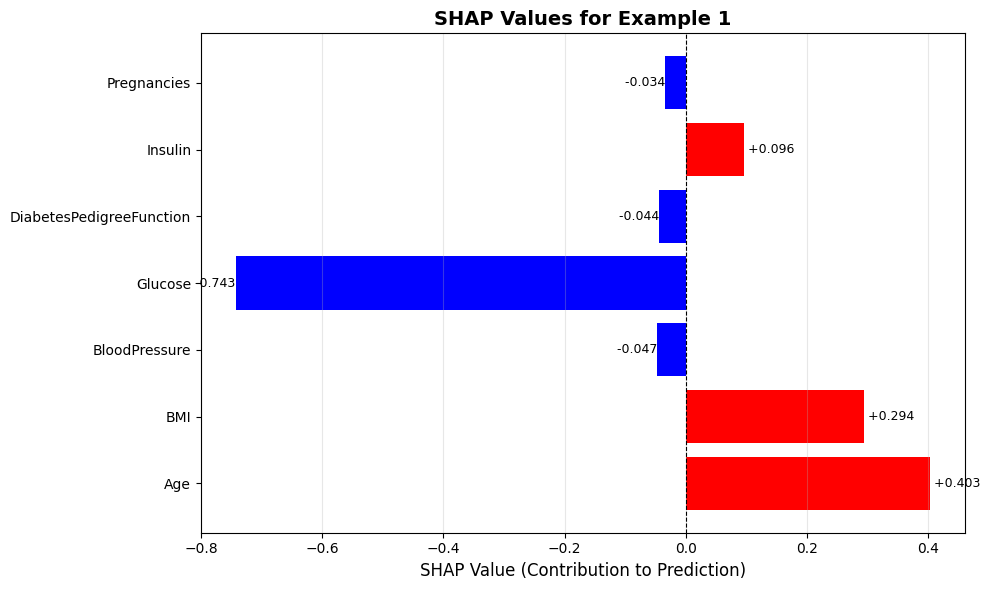

In [9]:
# Select a few examples to explain
# Choose examples with different outcomes
example_indices = []

# Find examples with diabetes (Outcome = 1)
diabetes_indices = df[df['Outcome'] == 1].index
if len(diabetes_indices) > 0:
    # Get index in X_sample
    sample_diabetes_idx = X_sample.index.intersection(diabetes_indices)
    if len(sample_diabetes_idx) > 0:
        example_indices.append(X_sample.index.get_loc(sample_diabetes_idx[0]))

# Find examples without diabetes (Outcome = 0)
no_diabetes_indices = df[df['Outcome'] == 0].index
if len(no_diabetes_indices) > 0:
    sample_no_diabetes_idx = X_sample.index.intersection(no_diabetes_indices)
    if len(sample_no_diabetes_idx) > 0:
        example_indices.append(X_sample.index.get_loc(sample_no_diabetes_idx[0]))

# If we have examples, show force plots
if len(example_indices) > 0:
    print("=" * 60)
    print("INDIVIDUAL PREDICTION EXPLANATIONS")
    print("=" * 60)
    
    # Extract positive class SHAP values if needed (for 3D arrays)
    if len(shap_values.shape) == 3:
        shap_values_for_plot = shap_values[:, :, 1]  # Extract class 1 (diabetes)
    else:
        shap_values_for_plot = shap_values
    
    # Get expected value - ensure it's a scalar (float)
    if isinstance(explainer.expected_value, list):
        expected_val = float(explainer.expected_value[1])
    elif isinstance(explainer.expected_value, np.ndarray):
        expected_val = float(explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0])
    else:
        expected_val = float(explainer.expected_value)
    
    for idx in example_indices[:2]:  # Show first 2 examples
        actual_idx = X_sample.index[idx]
        actual_outcome = y.loc[actual_idx]
        prediction = model.predict_proba(X_sample.iloc[[idx]])[0]
        
        print(f"\nExample {idx + 1}:")
        print(f"  Actual Outcome: {'Diabetes' if actual_outcome == 1 else 'No Diabetes'}")
        print(f"  Predicted Probability (Diabetes): {prediction[1]:.3f}")
        print(f"  Predicted Probability (No Diabetes): {prediction[0]:.3f}")
        print(f"  Predicted Class: {'Diabetes' if prediction[1] > 0.5 else 'No Diabetes'}")
        print(f"\n  Feature Values:")
        for feature in selected_features:
            print(f"    {feature}: {X_sample.iloc[idx][feature]:.2f}")
        
        # Create visualization of SHAP values
        # Note: SHAP v0.20+ has changed the API significantly, so we'll use a simple bar plot
        print(f"\n  SHAP Feature Contributions:")
        plot_created = False
        
        # Extract SHAP values for this instance
        instance_shap = shap_values_for_plot[idx]
        if isinstance(instance_shap, np.ndarray) and len(instance_shap.shape) > 1:
            instance_shap = instance_shap.flatten()
        
        # Create a simple bar plot showing feature contributions
        try:
            fig, ax = plt.subplots(figsize=(10, 6))
            colors = ['red' if val > 0 else 'blue' for val in instance_shap]
            bars = ax.barh(X_sample.columns, instance_shap, color=colors)
            ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
            ax.set_xlabel('SHAP Value (Contribution to Prediction)', fontsize=12)
            ax.set_title(f'SHAP Values for Example {idx + 1}', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for i, (bar, val) in enumerate(zip(bars, instance_shap)):
                ax.text(val, i, f' {val:+.3f}', va='center', 
                       ha='left' if val > 0 else 'right', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            plot_created = True
            
        except Exception as e:
            # If plotting fails, show as text
            print(f"  Base value: {expected_val:.4f}")
            print(f"  Feature contributions:")
            for i, feature in enumerate(X_sample.columns):
                shap_val = instance_shap[i] if i < len(instance_shap) else 0.0
                direction = "increases" if shap_val > 0 else "decreases"
                print(f"    {feature}: {float(shap_val):+.4f} ({direction} risk)")
else:
    print("Could not find suitable examples for visualization")


## Step 6: Save SHAP Explainer for Streamlit

Save the explainer so it can be used in the Streamlit application.


In [11]:
# Save the explainer for use in Streamlit
# Note: For tree-based models, we can save the explainer
# For kernel explainers, we'll save a smaller background dataset

explainer_filename = '../models/shap_explainer.pkl'

if 'Tree' in model_type or 'Forest' in model_type or 'XGB' in model_type or 'LGBM' in model_type:
    # Tree explainers can be saved directly
    joblib.dump(explainer, explainer_filename)
    print("=" * 60)
    print("SHAP EXPLAINER SAVED")
    print("=" * 60)
    print(f"\nExplainer saved to: {explainer_filename}")
    print("Type: TreeExplainer")
else:
    # For kernel explainers, save the background data and model
    # The explainer will be recreated in Streamlit
    background_data = X_sample if 'X_background' not in locals() else X_background
    joblib.dump({
        'explainer_type': 'kernel',
        'background_data': background_data,
        'model': model
    }, explainer_filename)
    print("=" * 60)
    print("SHAP EXPLAINER DATA SAVED")
    print("=" * 60)
    print(f"\nExplainer data saved to: {explainer_filename}")
    print("Type: KernelExplainer (will be recreated in Streamlit)")

# Also save feature importance for quick access
# Check if mean_shap was created in Cell 8
if 'mean_shap' in locals() or 'mean_shap' in globals():
    feature_importance_shap = {
        'features': selected_features,
        'importance_scores': mean_shap['Mean |SHAP Value|'].tolist()
    }
    
    with open('../models/shap_feature_importance.json', 'w') as f:
        json.dump(feature_importance_shap, f, indent=2)
    
    print(f"\nFeature importance saved to: ../models/shap_feature_importance.json")
else:
    print("\n⚠️ Warning: mean_shap not found. Please run Cell 8 first to generate feature importance.")
    print("Skipping feature importance save.")

print("\n✓ SHAP explainer ready for use in Streamlit app!")


SHAP EXPLAINER SAVED

Explainer saved to: ../models/shap_explainer.pkl
Type: TreeExplainer

Feature importance saved to: ../models/shap_feature_importance.json

✓ SHAP explainer ready for use in Streamlit app!


## Summary

In this notebook, we:
1. ✅ Loaded the best trained model
2. ✅ Created a SHAP explainer appropriate for the model type
3. ✅ Analyzed global feature importance
4. ✅ Explained individual predictions
5. ✅ Saved the explainer for use in Streamlit

**Key Insights:**
- SHAP values show how each feature contributes to predictions
- Positive SHAP values push toward diabetes prediction
- Negative SHAP values push toward no diabetes prediction
- Feature importance helps identify key risk factors

**Next Steps:** Proceed to Notebook 4 for Streamlit integration testing.
